# DSCI 552 | Homework 3 - AReM Data

### Time Series Classification Part 1: Feature Creation/Extraction

| Key             | Value           |
| --------------- | --------------- |
| Submitted By    | Ruchit Bhardwaj |
| USC ID          | 1111-4177-99    |
| Github Username | ruch0401        |


An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.

### 1(a). Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29. The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg_rss12, var_rss12, avg_rss13, var_rss13,vg_rss23, and ar_rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values

In [1]:
# performing all imports and installing prettytable during execution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import re
import csv
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [2]:
COLUMN_NAMES = ["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
OG_COLUMN_NAMES = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
STATS = ['mean', 'std', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']
ORDERED_STATS = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
ROOT = '../data/AReM/'
sniffer = csv.Sniffer()

### 1(b). Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [3]:
def split_train_test(root):
    train = []
    test = []
    for root, dir, file in os.walk(root):
        for f in file:
            if 'pdf' not in f:                
                fpof = os.path.join(root, f)
                if 'bending1' in fpof or 'bending2' in fpof:
                    if 'dataset1.csv' in fpof or 'dataset2.csv' in fpof:
                        test.append(fpof)
                    else:
                        train.append(fpof)
                else:
                    if 'dataset1.csv' in fpof or 'dataset2.csv' in fpof or 'dataset3.csv' in fpof:
                        test.append(fpof)
                    else:
                        train.append(fpof)
    return train, test

In [4]:
train, test = split_train_test(ROOT)

In [5]:
train

['../data/AReM/bending1/dataset7.csv',
 '../data/AReM/bending1/dataset6.csv',
 '../data/AReM/bending1/dataset4.csv',
 '../data/AReM/bending1/dataset5.csv',
 '../data/AReM/bending1/dataset3.csv',
 '../data/AReM/walking/dataset7.csv',
 '../data/AReM/walking/dataset6.csv',
 '../data/AReM/walking/dataset4.csv',
 '../data/AReM/walking/dataset5.csv',
 '../data/AReM/walking/dataset10.csv',
 '../data/AReM/walking/dataset11.csv',
 '../data/AReM/walking/dataset13.csv',
 '../data/AReM/walking/dataset12.csv',
 '../data/AReM/walking/dataset15.csv',
 '../data/AReM/walking/dataset14.csv',
 '../data/AReM/walking/dataset8.csv',
 '../data/AReM/walking/dataset9.csv',
 '../data/AReM/bending2/dataset6.csv',
 '../data/AReM/bending2/dataset4.csv',
 '../data/AReM/bending2/dataset5.csv',
 '../data/AReM/bending2/dataset3.csv',
 '../data/AReM/standing/dataset7.csv',
 '../data/AReM/standing/dataset6.csv',
 '../data/AReM/standing/dataset4.csv',
 '../data/AReM/standing/dataset5.csv',
 '../data/AReM/standing/dataset

In [6]:
test

['../data/AReM/bending1/dataset1.csv',
 '../data/AReM/bending1/dataset2.csv',
 '../data/AReM/walking/dataset1.csv',
 '../data/AReM/walking/dataset2.csv',
 '../data/AReM/walking/dataset3.csv',
 '../data/AReM/bending2/dataset1.csv',
 '../data/AReM/bending2/dataset2.csv',
 '../data/AReM/standing/dataset1.csv',
 '../data/AReM/standing/dataset2.csv',
 '../data/AReM/standing/dataset3.csv',
 '../data/AReM/sitting/dataset1.csv',
 '../data/AReM/sitting/dataset2.csv',
 '../data/AReM/sitting/dataset3.csv',
 '../data/AReM/lying/dataset1.csv',
 '../data/AReM/lying/dataset2.csv',
 '../data/AReM/lying/dataset3.csv',
 '../data/AReM/cycling/dataset1.csv',
 '../data/AReM/cycling/dataset2.csv',
 '../data/AReM/cycling/dataset3.csv']

### 1(c). Feature Extraction. 
### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

### 1(c)(i). Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

- maximum
- minimum
- mean
- median
- standard deviation
- first quartile
- third quartile
- correlation structure
- distribution
- entropy
- stationarity
- scaling properties

### 1(c)(ii). Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [7]:
def get_label(file):
    parent_directory = os.path.dirname(file)
    filename_components = parent_directory.split("/")
    return filename_components[-1]

def get_separator(file):
    f = open(file)
    return sniffer.sniff(f.read()).delimiter

def get_columns():
    feature = []
    for i in range(1, 7):
        for stat in STATS:
            feature.append(f'{stat}{i}')
    return feature
    
def load_data(files, feature, cols, segs=1, standard=False):
    import csv
    
    instances  = []
    labels = []
    for f in files:
        labels.append(get_label(f))
        separator = get_separator(f)
        
        if separator == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        elif separator == "\\s+":
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
            
        fc.columns = OG_COLUMN_NAMES
        
        # breaking time series into equal lengths
        seg_length = int(fc.shape[0] / segs)
        description = []
        for i in range(segs):
            start1 = i * seg_length
            end1 = min((i + 1) * seg_length, fc.shape[0])
            cur_seg = fc[start1 : end1]
            time_col = "# Columns: time"
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            description.append(cur_describe.values.flatten())

        instances.append(np.concatenate(description))
            
    # reordering
    feature_df = pd.DataFrame(instances)
    feature_df.columns = get_columns()
    feature_df = feature_df.loc[:, feature]
    
    # label addition
    feature_df['label'] = pd.Series(labels)
    
    return feature_df

In [8]:
def get_actual_ordered_cols():
    feature = []
    for i in range(1, 7):
        for stat in ORDERED_STATS:
            feature.append(f'{stat}{i}')
    return feature

In [9]:
feature = get_actual_ordered_cols()

train_data = load_data(train, feature, OG_COLUMN_NAMES)
test_data = load_data(test, feature, OG_COLUMN_NAMES)

In [10]:
train_data

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.310,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.830,bending1
1,37.00,48.00,43.454958,43.25,1.386098,42.500,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.870,bending1
2,33.00,47.75,42.179813,43.50,3.670666,39.150,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.000,bending1
3,33.00,45.75,41.678063,41.75,2.243490,41.330,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.500,bending1
4,35.00,47.40,43.954500,44.33,1.558835,43.000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.940,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.060,cycling
65,24.25,45.00,37.177042,36.25,3.581301,34.500,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
66,23.33,43.50,36.248768,36.75,3.824632,33.415,39.25,0.0,9.71,2.737307,...,15.7500,21.0000,0.0,11.15,3.532463,3.110,1.965267,2.1700,4.625,cycling
67,26.25,44.25,36.957458,36.29,3.434863,34.500,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.030,cycling


In [11]:
test_data

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,19.33,43.50,34.227771,35.500,4.889576,30.5000,37.7500,0.0,14.50,3.995729,...,14.7500,18.6700,0.0,9.74,3.394125,3.100,1.792090,2.1050,4.425,walking
3,12.50,45.00,33.509729,34.125,4.850923,30.5000,36.7500,0.0,13.05,4.450771,...,14.6275,18.7500,0.0,8.96,3.378479,3.085,1.787360,2.0600,4.440,walking
4,15.00,46.75,34.660583,35.000,5.315110,31.0000,38.2500,0.0,13.44,4.200896,...,14.2500,18.5000,0.0,8.99,3.244396,3.000,1.630983,2.1200,4.240,walking
5,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
6,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
7,33.33,48.00,44.334729,45.000,2.476940,42.2500,46.5000,0.0,3.90,0.432958,...,9.3300,17.7500,0.0,5.02,0.933000,0.830,0.673609,0.4700,1.250,standing
8,35.50,46.25,43.174938,43.670,1.989052,42.5000,44.5000,0.0,2.12,0.506583,...,12.7500,16.5000,0.0,5.72,0.911979,0.830,0.666161,0.4700,1.220,standing
9,32.75,47.00,42.760563,44.500,3.398919,41.3300,45.3725,0.0,3.34,0.486167,...,13.0000,18.5650,0.0,5.73,0.842271,0.710,0.722165,0.4300,1.090,standing


### 1(c)(iii). Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [12]:
train_data.describe().loc['std']

min1             8.794295
max1             4.429182
mean1            4.917678
median1          4.956111
std1             1.758647
1st_quartile1    5.731647
3rd_quartile1    4.783645
min2             0.000000
max2             5.147841
mean2            1.600675
median2          1.436903
std2             0.902805
1st_quartile2    0.952201
3rd_quartile2    2.158258
min3             3.053869
max3             4.759853
mean3            3.863099
median3          3.845730
std3             0.995975
1st_quartile3    4.145255
3rd_quartile3    3.946023
min4             0.000000
max4             2.302408
mean4            1.179837
median4          1.150092
std4             0.473545
1st_quartile4    0.842501
3rd_quartile4    1.566564
min5             5.368786
max5             5.449726
mean5            5.120450
median5          5.267414
std5             1.057972
1st_quartile5    5.543882
3rd_quartile5    4.957231
min6             0.051766
max6             2.540166
mean6            1.171353
median6     

In [13]:
test_data.describe().loc['std']

min1             12.136206
max1              4.379342
mean1             6.790086
median1           7.088085
std1              1.869285
1st_quartile1     7.673052
3rd_quartile1     6.385720
min2              0.000000
max2              4.870395
mean2             1.500529
median2           1.345903
std2              0.832472
1st_quartile2     0.941307
3rd_quartile2     2.028482
min3              2.644618
max3              5.393220
mean3             4.588252
median3           4.753522
std3              0.760779
1st_quartile3     4.554121
3rd_quartile3     5.014339
min4              0.000000
max4              1.733937
mean4             1.146338
median4           1.161705
std4              0.409008
1st_quartile4     0.867088
3rd_quartile4     1.541943
min5              8.252947
max5              6.782153
mean5             7.366781
median5           7.438749
std5              0.919274
1st_quartile5     7.823870
3rd_quartile5     7.259433
min6              0.000000
max6              2.505306
m

In [19]:
data = train_data.iloc[:, :-1]
ans = []
for sample in range(1000):
    resampled = resample(data)
    temp = resampled.apply(lambda col: np.std(col))
    ans.append(temp)

ans = pd.DataFrame(ans)
ans.columns = list(data.columns)
interval = ans.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
interval.apply(np.around, args=(2,))
interval = interval.T
interval.columns = ['low', 'high']
interval


,low,high
min1,7.405927,9.910039
max1,3.315984,5.454500
mean1,4.285809,5.397982
median1,4.310201,5.461052
std1,1.538808,1.926846
1st_quartile1,5.112453,6.185343
3rd_quartile1,3.908026,5.553176
min2,0.000000,0.000000
max2,4.602818,5.488958
mean2,1.383466,1.721145


### 1(c)(iv). Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)

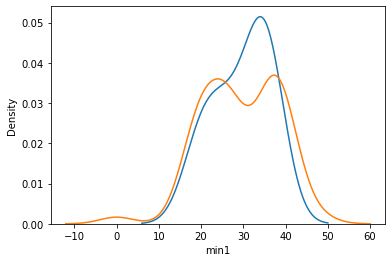

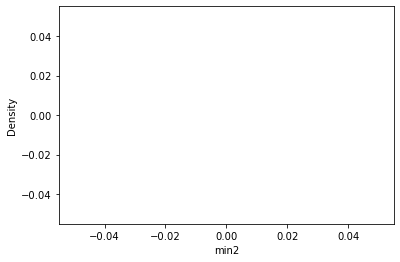

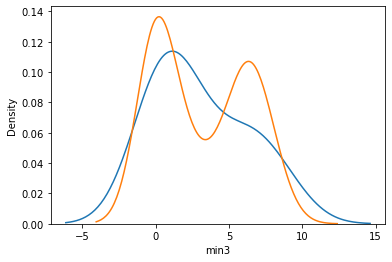

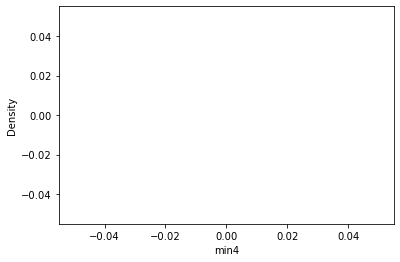

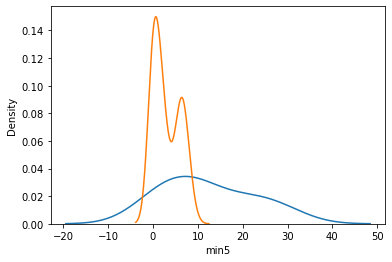

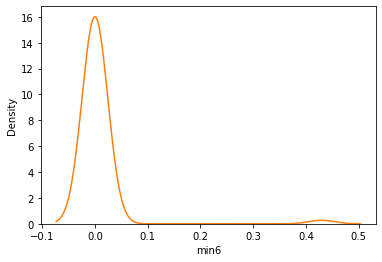

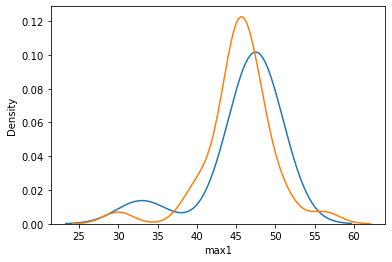

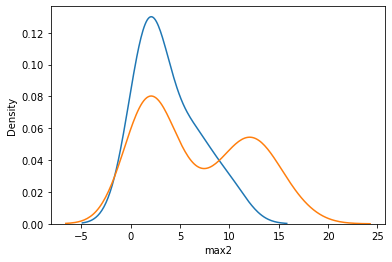

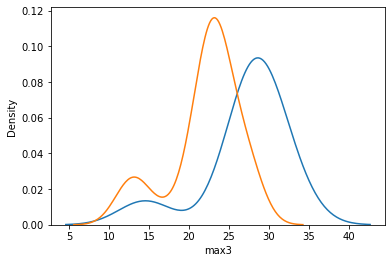

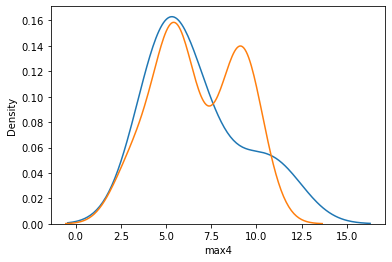

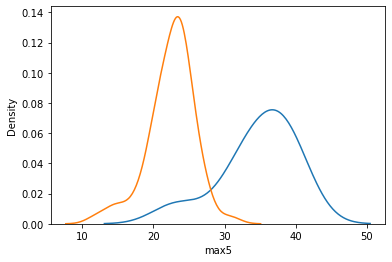

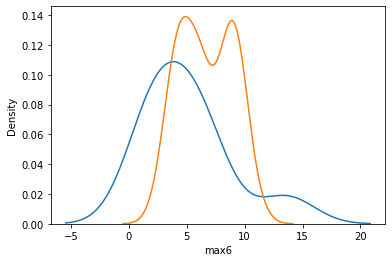

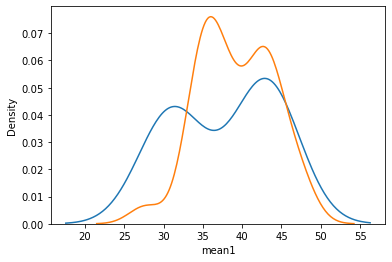

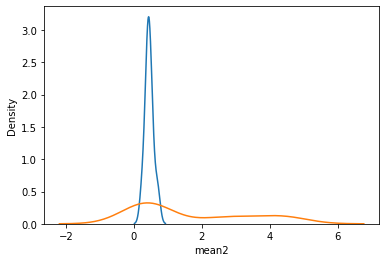

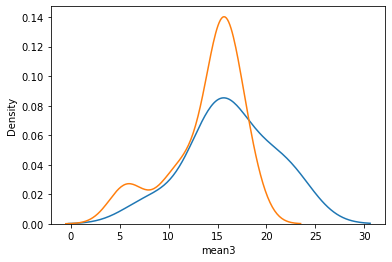

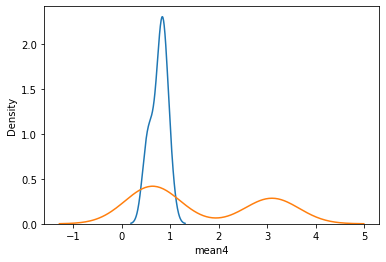

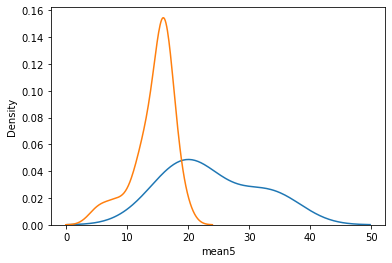

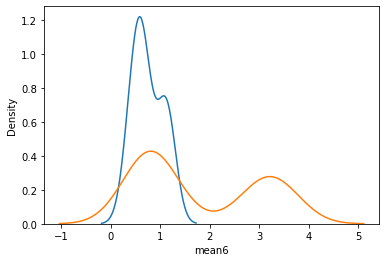

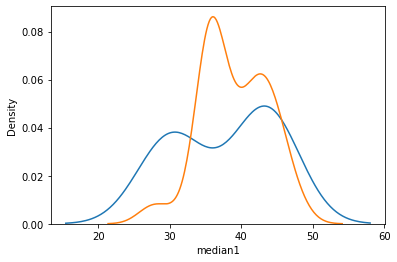

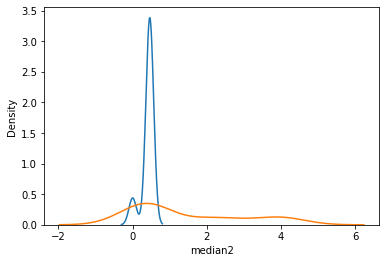

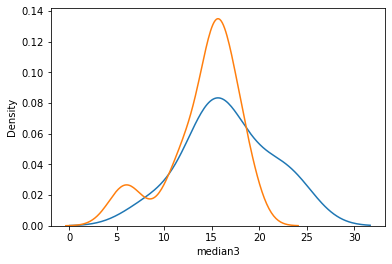

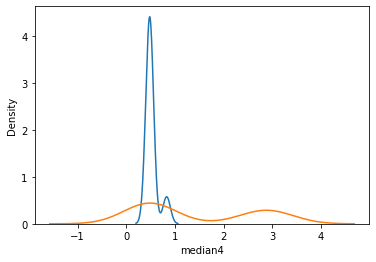

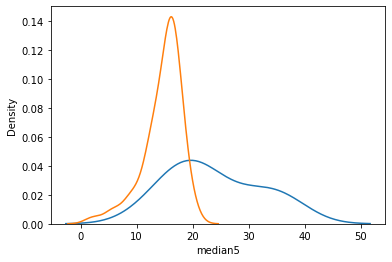

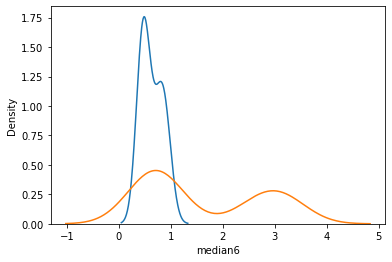

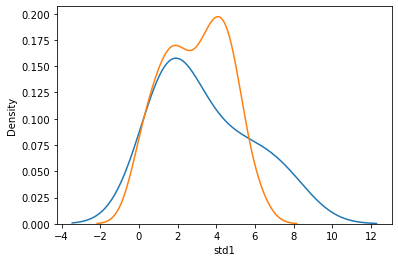

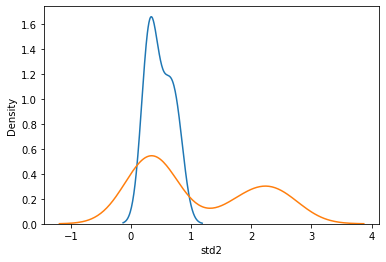

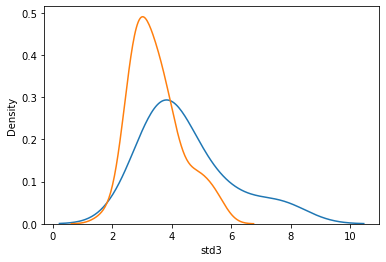

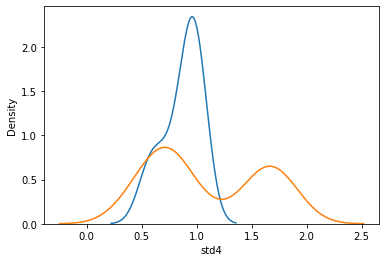

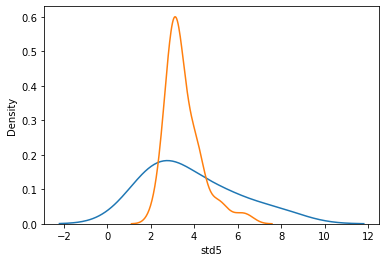

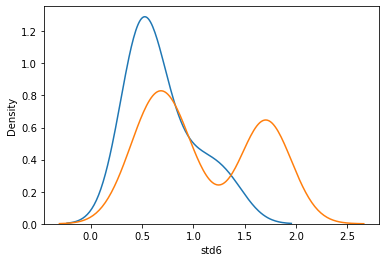

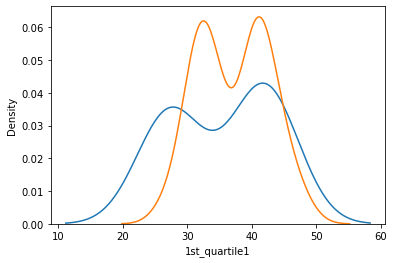

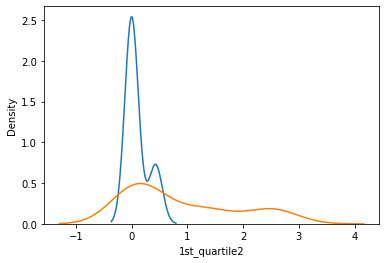

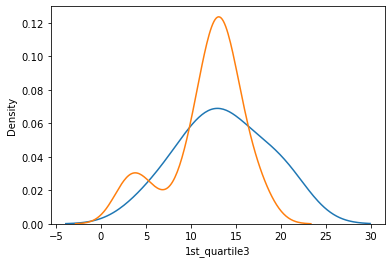

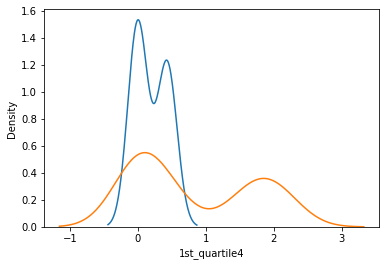

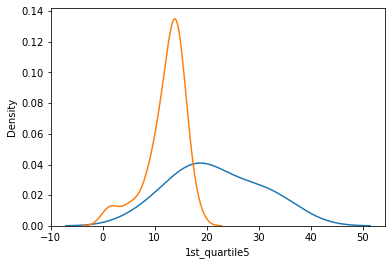

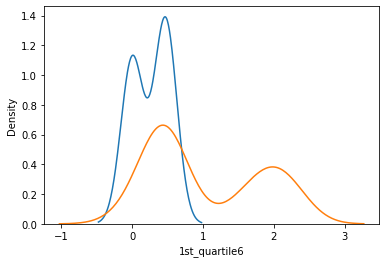

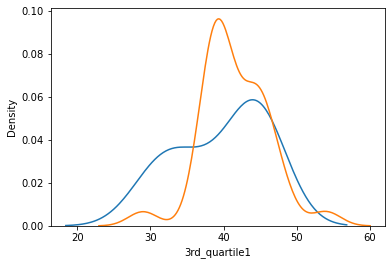

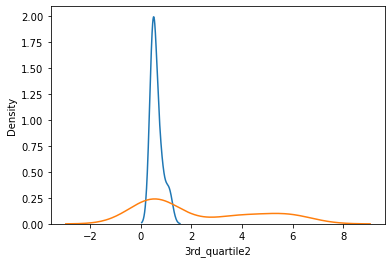

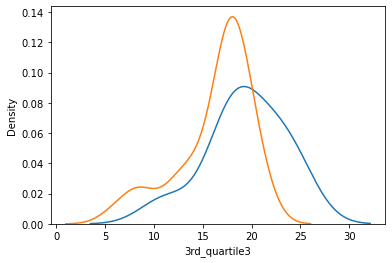

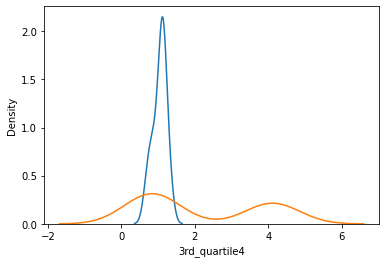

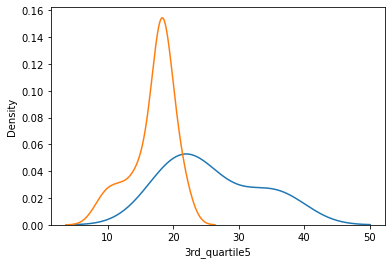

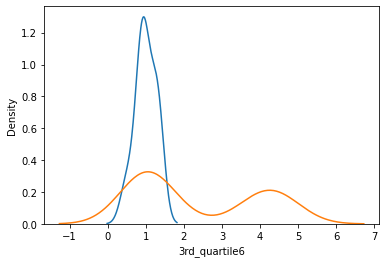

In [15]:
# converting label from text to 1 or 0 depending on whether the label is ('bending1', 'bending2') or not respectively
train_df = pd.DataFrame(train_data)
temp = train_df['label']
train_df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
train_df.loc[temp != 1, 'label'] = 0
train_data


    
for stat in ORDERED_STATS:
    for i in range(1, 7):
        bending_df = train_data.loc[train_data['label'] == 1, stat + str(i)]
        not_bending_df = train_data.loc[train_data['label'] == 0, stat + str(i)]
        sns.distplot(bending_df, label='Bending', kde='True', hist = False)
        sns.distplot(not_bending_df, label='Not Bending', kde='True', hist = False)
        plt.show()

Since this is a regression problem, the choice of important time-domain features will be majorly driven by the feasibility of demarkation and there should be relatively clear separated distribution and hence the choice would be - 
- min
- max
- 3rd quartile

### 2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Answer:** Since predictors are directly proportional to the fitting of the model, the RSS for linear regression would be higher as compared to the RSS for cubic regression since cubic regression has more predictors and thus would ideally have a better fit on a regression model.


(b) Answer (a) using test rather than training RSS.

**Answer:** More predictors generally leads to overfitting using the test data. So, for the test case, the RSS for linear regression will be lower since it is more likely to provide relatively correct regression result.


(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Answer:** The fundamental principle does not change. More predictors lead to less RSS and hence, the RSS for cubic would be less. Cubic regression has more flexibility.


(d) Answer (c) using test rather than training RSS.

**Answer:** The information provided is insufficient as the answer will depend on the finding of which regression is the actual answer closer to.